In [1]:
import pickle
import pandas as pd
import numpy as np
import logging

In [2]:
%matplotlib inline

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)

In [4]:
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")

DEBUG:root:test


In [13]:
def setting_training_test(dataframe, startdate, splitdate):
    #start_date = pd.datetime(startdate)
    ParentingAfter2012 = dataframe.loc[dataframe['created_utc'] > start_date]
    #separate the training and test data
    #split_date = pd.datetime(splitdate)
    df_training = ParentingAfter2012.loc[ParentingAfter2012['created_utc'] <= split_date]
    df_test = ParentingAfter2012.loc[ParentingAfter2012['created_utc'] > split_date]
    return df_training, df_test

In [14]:
def create_dad(dataframe):
    
    dataframe['DadBody']= dataframe.body.str.match('dad here|I am a dad|I\'m a dad|I am a father|father here|I\'m a father|I am a SAHD|I`m a SAHD|I was a SAHD|I am a stay-at-home father|I\'m a stay-at-home father|I was a stay-at-home father|I was a stay-at-home dad|I was a sahd')
    dataframe['DadAuthor'] = dataframe.author.str.contains('dad|daddy|dada|father', na=False)
    
    return dataframe

In [15]:
def create_mom(dataframe):
    
    dataframe['MomBody'] = dataframe.body.str.match('I\'m a mum|I am a mum|mum here|mom here|I am a mom|I\'m a mom|I am a mother|mother here|I\'m a mother| I am a stay-at-home mom|I\'m a stay-at-home mom|I was a stay-at-home mom|I was a sahm')
    dataframe['MomAuthor'] = dataframe.author.str.contains('mom|mother|mama|mum', na=False)

    
    return dataframe

In [16]:
def create_two_gender_df(dataframe):
    
    dataframe['Gendered'] = (dataframe.DadBody>0) | (dataframe.DadAuthor>0) | (dataframe.MomBody>0) | (dataframe.MomAuthor>0)
    
    return dataframe

In [17]:
def create_throwaway_df(dataframe):
    dataframe['body'] = dataframe['body'].str.lower()
    dataframe['author'] = dataframe['author'].str.lower()
    dataframe['ThrowAuth'] = dataframe.author.str.contains('thrw|throwaway|throw|thrw|thraway', na=False)

    dataframe['ThrowBody'] = dataframe.body.str.match('this is a throwaway|I am using a throwaway|I\'m using a throwawy')

    return dataframe

In [239]:
#Prepare the IV's from dataframe
#add throwaway variable
def prepare_data_for_models(dataframe):
    dataframe_piv = pd.pivot_table(dataframe, index= 'author', aggfunc= 'mean')
    #setting the users of more than one subreddit
    #for example, only r/Daddit and r/Mommit
    dataframe_piv['DM'] =  (dataframe_piv.daddit>0) & (dataframe_piv.Mommit>0) & (dataframe_piv.Parenting==0)
    dataframe_piv['PD'] =  (dataframe_piv.Parenting>0) & (dataframe_piv.daddit>0) & (dataframe_piv.Mommit==0)
    dataframe_piv['PM'] =  (dataframe_piv.Parenting>0) & (dataframe_piv.Mommit>0) & (dataframe_piv.daddit==0)
    dataframe_piv['PMD'] =  (dataframe_piv.daddit>0) & (dataframe_piv.Mommit>0) & (dataframe_piv.Parenting>0)
    
    dataframe_piv['Dad'] = (dataframe_piv.DadBody>0) | (dataframe_piv.DadAuthor>0)
    dataframe_piv['Dad'] = dataframe_piv['Dad']*1
    dataframe_piv['Dad'].fillna(0, inplace=True)
    dataframe_piv['Dad'] = dataframe_piv['Dad'].astype('int')
    
    dataframe_piv['Mom'] = (dataframe_piv.MomBody>0) | (dataframe_piv.MomAuthor>0)
    dataframe_piv['Mom'] = dataframe_piv['Mom']*1
    dataframe_piv['Mom'].fillna(0, inplace=True)
    dataframe_piv['Mom'] = dataframe_piv['Mom'].astype('int')
    
    dataframe_piv['Gendered'] = (dataframe_piv.Mom>0) ^ (dataframe_piv.Dad>0)
    
    #dataframe_piv['Gendered'] = dataframe_piv.mask(dataframe_piv.Gendered>0)
    dataframe_piv['Gendered'] = dataframe_piv['Gendered']*1
    dataframe_piv['Gendered'].fillna(0, inplace=True)
    dataframe_piv['Gendered'] = dataframe_piv['Gendered'].astype('int')
    
        
    dataframe_piv['Throwaway'] = (dataframe_piv.ThrowAuth>0) | (dataframe_piv.ThrowBody>0)
    
    dataframe_piv['Throwaway'] = dataframe_piv['Throwaway']*1
    dataframe_piv['Throwaway'].fillna(0, inplace=True)
    dataframe_piv['Throwaway'] = dataframe_piv['Throwaway'].astype('int')
    
    dataframe_piv['Respond'] = (dataframe_piv.Respond>0)

    return dataframe_piv

In [94]:
Features = ['Stroller/Carrier selection', 'Food prep', 'Babyproofing',  'Tech & Media Consumption', 'Child media', 'Child play', 'Sociopolitical beleifs', 'Children Books', 'Cloth diapers', 'Work-life Balance', 'Breastfeeding', 'Money discussion', 'Early dev', 'Dev. & sib. interaction', 'Gift ideas', 'Child sickness', 'Time-chore mngt','Education', 'Preg & birth', 'Psych state of child & Parent', 'Congrats/announcements', 'Judgement', 'Discipline', 'Lang dev', 'Parenting hardships', 'Interaction with (extended)fam.', 'Child abuse/custody', 'Funny', 'Traveling & vacations', 'Parenting ID',
       'Vaccines', 'Teen/sex talk','Corp. punishment', 'Potty training', 'Sleep training', 'score', 'tenure', 'negative_emotion', 'positive_emotion', 'comment_length', 'Parenting', 'Mommit', 'daddit', 'Gendered']

In [19]:
ParentingWithScores = pd.read_pickle('ParentingRedditUsers.pickle')

In [20]:
Thrw = create_throwaway_df(ParentingWithScores)
Dad_df = create_dad(ParentingWithScores)
Mom_df = create_mom(Dad_df)

In [21]:
Prepared = prepare_data_for_models(Mom_df)

In [22]:
Dads = Prepared[Prepared['Dad']==1]
Moms = Prepared[Prepared['Mom']==1]
Gendered = Prepared[Prepared['Gendered']==1]
Throwaway = Prepared[Prepared['Throwaway']==1]

In [23]:
#There are 28 users who identified both as mothers and fathers. They are kept out of the "gendered" feature for now
#still thinking about whether we should include them in the analysis. 
print(len(Dads.index))
print(len(Moms.index))
print(len(Gendered.index))
print(len(Throwaway.index))

1228
2280
3480
1101


# Training for Throwway model

In [24]:
Features = ['Stroller/Carrier selection', 'Food prep', 'Babyproofing',  'Tech & Media Consumption', 'Child media', 'Child play', 'Sociopolitical beleifs', 'Children Books', 'Cloth diapers', 'Work-life Balance', 'Breastfeeding', 'Money discussion', 'Early dev', 'Dev. & sib. interaction', 'Gift ideas', 'Child sickness', 'Time-chore mngt','Education', 'Preg & birth', 'Psych state of child & Parent', 'Congrats/announcements', 'Judgement', 'Discipline', 'Lang dev', 'Parenting hardships', 'Interaction with (extended)fam.', 'Child abuse/custody', 'Funny', 'Traveling & vacations', 'Parenting ID',
       'Vaccines', 'Teen/sex talk','Corp. punishment', 'Potty training', 'Sleep training', 'score', 'tenure', 'negative_emotion', 'positive_emotion', 'comment_length', 'Parenting', 'Mommit', 'daddit', 'Gendered']

In [25]:
Feature_Names = ['Stroller/Carrier selection', 'Food prep', 'Babyproofing', 'Tech Media  Consumption', 'Child media', 'Child play', 'Sociopolitical beliefs', 'Children Books', 'Cloth diapers', 'Work-life Balance', 'Breastfeeding', 'Money discussion', 'Early dev', 'Dev. sib. interaction', 'Gift ideas', 'Child sickness', 'Time-chore mngt', 'Education', 'Preg birth', 'Psych state of child Parent', 'Congrats/announcements', 'Judgement', 'Discipline', 'Lang dev', 'Parenting hardships', 'Interaction with (extended)fam.', 'Child abuse/custody', 'Funny', 'Traveling vacations', 'Parenting ID', 'Vaccines', 'Teen/sex talk', 'Corp. punishment', 'Potty training', 'Sleep training','score', 'tenure', 'negative emotions', 'positive emotions' , 'comment length', 'r/Parenting', 'r/Mommit', 'r/Daddit', 'Gendered']

In [26]:
start_date = pd.datetime(2012,1,1)
split_date = pd.datetime(2016,1,1)

Thrw = create_throwaway_df(ParentingWithScores)
Dad_df = create_dad(ParentingWithScores)
Mom_df = create_mom(Dad_df)

df_training, df_test = setting_training_test(Mom_df, startdate=start_date, splitdate=split_date )

In [27]:
df_training = prepare_data_for_models(df_training)
df_test = prepare_data_for_models(df_test)

In [32]:
df = Mom_df.copy()

In [33]:
df_prep = prepare_data_for_models(df)

In [34]:
df_stats = df_prep.drop([''])

In [28]:
df_training = df_training.drop([''])
df_test = df_test.drop([''])

In [29]:
df_training.to_pickle('df_training.pickle')
df_test.to_pickle('df_test.pickle')

In [48]:
df_Psuedonymous = df_stats[df_stats['Throwaway']==0]
df_Throwaway = df_stats[df_stats['Throwaway']==1]

The two dataframes will need to be balanced and the values scaled before working on the classifiers. 

In [244]:
Joined

Mommit  Parenting  daddit archived  \
link_id   created_utc                                               
t3_6d8mw  2008-04-09 15:16:05  0       1          0       True      
t3_6d8mh  2008-04-09 15:17:46  0       1          0       True      
t3_7l42c  2008-12-23 14:58:04  0       1          0       True      
t3_6ikpd  2008-05-08 19:14:57  0       1          0       True      
t3_7xo64  2009-02-16 15:54:40  0       1          0       True      
t3_8u9xm  2009-06-21 23:16:13  0       1          0       True      
t3_boqpq  2010-04-10 01:36:22  0       1          0       True      
t3_bt9b7  2010-04-19 21:34:26  0       1          0       True      
          2010-04-24 21:34:14  0       1          0       True      
t3_d7v6b  2010-08-31 20:50:51  0       1          0       True      
t3_edtla  2010-12-01 01:29:09  0       1          0       True      
          2010-12-01 01:34:01  0       1          0       True      
          2010-12-01 01:41:11  0       1          0       True      
          2010-12-01 03:31:39  0       1          0       True      
t3_eefz3  2010-12-01 18:25:35  0       1          0       True      
t3_eqs6n  2010-12-24 13:32:35  0       1          0       True      
t3_etail  2010-12-30 01:08:17  0       1          0       True      
t3_cmwgt  2010-07-08 17:15:26  0       1          0       True      
t3_chbb7  2010-06-21 18:32:46  0       1          0       True      
t3_cch0n  2010-06-21 18:35:41  0       1          0       True      
t3_dzrma  2010-11-02 19:31:43  0       1          0       True      
t3_e9h7q  2010-11-22 02:03:50  0       1          0       True      
          2010-11-22 15:16:21  0       1          0       True      
          2010-11-23 00:59:04  0       1          0       True      
t3_edtla  2010-11-30 14:27:46  0       1          0       True      
          2010-11-30 19:41:20  0       1          0       True      
t3_dlgzg  2010-10-02 12:44:55  0       1          0       True      
          2010-10-02 12:45:31  0       1          0       True      
          2010-10-02 19:03:40  0       1          0       True      
          2010-10-02 19:05:46  0       1          0       True      
...                           ..      ..         ..        ...      
t3_5l9iu3 2016-12-31 16:18:37  0       0          1       0         
t3_5l9fby 2016-12-31 16:19:33  0       0          1       0         
t3_5l659u 2016-12-31 16:22:00  0       0          1       0         
t3_5l8vrl 2016-12-31 16:23:44  0       0          1       0         
t3_5l4kf7 2016-12-31 16:24:30  0       0          1       0         
t3_5l7dbd 2016-12-31 16:43:50  0       0          1       0         
          2016-12-31 19:30:51  0       0          1       0         
t3_5l4kf7 2016-12-31 16:49:43  0       0          1       0         
t3_5l7dbd 2016-12-31 16:50:15  0       0          1       0         
          2016-12-31 17:40:09  0       0          1       0         
          2016-12-31 17:58:02  0       0          1       0         
          2016-12-31 18:20:08  0       0          1       0         
          2016-12-31 18:26:16  0       0          1       0         
          2016-12-31 18:38:08  0       0          1       0         
          2016-12-31 19:15:38  0       0          1       0         
          2016-12-31 20:07:39  0       0          1       0         
t3_5jz199 2016-12-31 20:25:26  0       0          1       0         
t3_5ladf2 2016-12-31 20:36:34  0       0          1       0         
t3_5l3hz6 2016-12-31 20:43:52  0       0          1       0         
t3_5l84n5 2016-12-31 21:20:37  0       0          1       0         
t3_5l9iu3 2016-12-31 22:14:59  0       0          1       0         
          2016-12-31 22:21:55  0       0          1       0         
t3_5l7dbd 2016-12-31 22:15:51  0       0          1       0         
          2016-12-31 22:36:36  0       0          1       0         
t3_5lbkvv 2016-12-31 22:39:44  0       0          1       0         
t3_5ladf2 2016-12-31 22:45:59

In [ ]:
df_Throwaway = pd.read

Text(0.5,0.98,'Tenure of Pseudonymous and throwaway accounts')

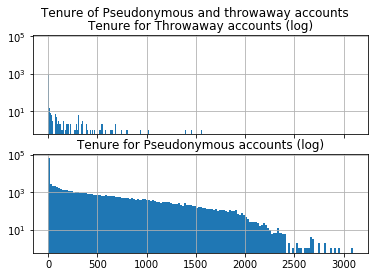

In [113]:
f, axarr = plt.subplots(2, sharex=True, sharey=True)
axarr[0].set_title('Tenure for Throwaway accounts (log)')
axarr[0].set_yscale('log')
df_Throwaway['tenure'].hist(ax=axarr[0], stacked=False, bins=150)
axarr[1].set_title('Tenure for Pseudonymous accounts (log)')
axarr[1].set_yscale('log')
df_Psuedonymous['tenure'].hist(ax=axarr[1], stacked=False, bins=150)
f.suptitle('Tenure of Pseudonymous and throwaway accounts')

In [142]:
df_stats.columns

Index(['Babyproofing', 'Breastfeeding', 'Child abuse/custody', 'Child media',
       'Child play', 'Child sickness', 'Children Books', 'Cloth diapers',
       'Congrats/announcements', 'Corp. punishment', 'DadAuthor', 'DadBody',
       'Dev. & sib. interaction', 'Discipline', 'Early dev', 'Education',
       'Food prep', 'Funny', 'Gift ideas', 'Interaction with (extended)fam.',
       'Judgement', 'Lang dev', 'MomAuthor', 'MomBody', 'Mommit',
       'Money discussion', 'Parenting', 'Parenting ID', 'Parenting hardships',
       'Potty training', 'Preg & birth', 'Psych state of child & Parent',
       'Sleep training', 'Sociopolitical beleifs',
       'Stroller/Carrier selection', 'Tech & Media Consumption',
       'Teen/sex talk', 'ThrowAuth', 'ThrowBody', 'Time-chore mngt',
       'Traveling & vacations', 'Vaccines', 'Work-life Balance',
       'comment_length', 'controversiality', 'daddit', 'downs', 'gilded',
       'negative_emotion', 'positive_emotion', 'removal_reason', 'score',
  

In [150]:
thro_name_status = pd.DataFrame(df_stats['Throwaway'])

In [151]:
#thinking of joining the two dataframes
Joined = pd.merge(Mom_df, thro_name_status, on='author')

In [152]:
len(Joined)

1837643

In [153]:
len(Joined[Joined['Throwaway']==1])

6991

In [245]:
Joined.head()

,,Mommit,Parenting,daddit,archived,author,author_flair_css_class,author_flair_text,body,controversiality,distinguished,downs,edited,gilded,name,parent_id,removal_reason,score,score_hidden,subreddit,ups,body_tokenized,Stroller/Carrier selection,Food prep,Babyproofing,Tech & Media Consumption,Child media,Child play,Sociopolitical beleifs,Children Books,Cloth diapers,Work-life Balance,Breastfeeding,Money discussion,Early dev,Dev. & sib. interaction,Gift ideas,Child sickness,Time-chore mngt,Education,Preg & birth,Psych state of child & Parent,Congrats/announcements,Judgement,Discipline,Lang dev,Parenting hardships,Interaction with (extended)fam.,Child abuse/custody,Funny,Traveling & vacations,Parenting ID,Vaccines,Teen/sex talk,Corp. punishment,Potty training,Sleep training,comment_length,positive_emotion,negative_emotion,created_utcmin,created_utcmax,tenure,ThrowAuth,ThrowBody,DadBody,DadAuthor,MomBody,MomAuthor,Throwaway,Respond
link_id,created_utc,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
t3_6d8mw,2008-04-09 15:16:05,0,1,0,True,kickstand,0,0,now you tell me. :-(,0,0,0.0,1970-01-01,0,t1_c03o5z1,t3_6d8mw,0.0,1,False,Parenting,1.0,[tel],0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.51000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,0.0,0.000000,2008-04-09 15:16:05,2014-12-09 23:43:23,2435,False,False,False,False,False,False,0,False
t3_6d8mh,2008-04-09 15:17:46,0,1,0,True,kickstand,0,0,"at our house, the tooth fairy leaves one shiny $1 coin with a dead white president's face on it.\n\nhttp://www.usmint.gov/mint_programs/$1coin/index.cfm?flash=yes",0,0,0.0,1970-01-01,0,t1_c03o5zp,t3_6d8mh,0.0,1,False,Parenting,1.0,"[hous, too, fairy, leav, on, shiny, coin, dead, whit, presid, fac]",0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.62691,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19,0.0,0.050000,2008-04-09 15:16:05,2014-12-09 23:43:23,2435,False,False,False,False,False,False,0,False
t3_7l42c,2008-12-23 14:58:04,0,1,0,True,kickstand,0,0,"it's not really much of a guide, is it?",0,0,0.0,1970-01-01,0,t1_35d8,t3_7l42c,0.0,3,False,Parenting,3.0,"[real, much, guid]",0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.755000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,0.0,0.000000,2008-04-09 15:16:05,2014-12-09 23:43:23,2435,False,False,False,False,False,False,0,False
t3_6ikpd,2008-05-08 19:14:57,0,1,0,True,kickstand,0,0,"whatever you do, don't make reading a chore. it's the most fun thing in the world, treat it as such.",0,0,0.0,1970-01-01,0,t1_c03y7ux,t3_6ikpd,0.0,1,False,Parenting,1.0,"[whatev, mak, read, chor, fun, thing, world, tre]",0.0,0.0,0.0,0.0,0.0,0.0,0.149695,0.164569,0.0,0.0,0.0,0.0,0.0,0.000000,0.397008,0.0,0.186506,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,0.0,0.000000,2008-04-09 15:16:05,2014-12-09 23:43:23,2435,False,False,False,False,False,False,0,False
t3_7xo64,2009-02-16 15:54:40,0,1,0,True,kickstand,0,0,"just because you have two kids doesn't mean they are going to get along, or even like each other.",0,0,0.0,1970-01-01,0,t1_c07p56l,t3_7xo64,0.0,1,False,Parenting,1.0,"[two, kid, mean, going, get, along, ev, lik]",0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.460527,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.432806,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19,0.0,0.052632,2008-04-09 15:16:05,2014-12-09 23:43:23,2435,False,False,False,False,False,False,0,False


In [155]:
#putting them in order by indexing by 
Joined = Joined.set_index(['link_id','created_utc'])

In [156]:
Joined.head(100)

Mommit  Parenting  daddit archived     author  \
link_id   created_utc                                                          
t3_6d8mw  2008-04-09 15:16:05  0       1          0       True     kickstand   
t3_6d8mh  2008-04-09 15:17:46  0       1          0       True     kickstand   
t3_7l42c  2008-12-23 14:58:04  0       1          0       True     kickstand   
t3_6ikpd  2008-05-08 19:14:57  0       1          0       True     kickstand   
t3_7xo64  2009-02-16 15:54:40  0       1          0       True     kickstand   
t3_8u9xm  2009-06-21 23:16:13  0       1          0       True     kickstand   
t3_boqpq  2010-04-10 01:36:22  0       1          0       True     kickstand   
t3_bt9b7  2010-04-19 21:34:26  0       1          0       True     kickstand   
          2010-04-24 21:34:14  0       1          0       True     kickstand   
t3_d7v6b  2010-08-31 20:50:51  0       1          0       True     kickstand   
t3_edtla  2010-12-01 01:29:09  0       1          0       True     kickstand   
          2010-12-01 01:34:01  0       1          0       True     kickstand   
          2010-12-01 01:41:11  0       1          0       True     kickstand   
          2010-12-01 03:31:39  0       1          0       True     kickstand   
t3_eefz3  2010-12-01 18:25:35  0       1          0       True     kickstand   
t3_eqs6n  2010-12-24 13:32:35  0       1          0       True     kickstand   
t3_etail  2010-12-30 01:08:17  0       1          0       True     kickstand   
t3_cmwgt  2010-07-08 17:15:26  0       1          0       True     kickstand   
t3_chbb7  2010-06-21 18:32:46  0       1          0       True     kickstand   
t3_cch0n  2010-06-21 18:35:41  0       1          0       True     kickstand   
t3_dzrma  2010-11-02 19:31:43  0       1          0       True     kickstand   
t3_e9h7q  2010-11-22 02:03:50  0       1          0       True     kickstand   
          2010-11-22 15:16:21  0       1          0       True     kickstand   
          2010-11-23 00:59:04  0       1          0       True     kickstand   
t3_edtla  2010-11-30 14:27:46  0       1          0       True     kickstand   
          2010-11-30 19:41:20  0       1          0       True     kickstand   
t3_dlgzg  2010-10-02 12:44:55  0       1          0       True     kickstand   
          2010-10-02 12:45:31  0       1          0       True     kickstand   
          2010-10-02 19:03:40  0       1          0       True     kickstand   
          2010-10-02 19:05:46  0       1          0       True     kickstand   
...                           ..      ..         ..        ...           ...   
t3_hf373  2011-05-19 16:40:36  0       1          0       True     kickstand   
          2011-05-19 16:47:09  0       1          0       True     kickstand   
t3_hiakd  2011-05-23 20:36:19  0       1          0       True     kickstand   
t3_n0hsv  2011-12-05 13:16:36  0       1          0       True     kickstand   
t3_nejfz  2011-12-16 14:28:30  0       1          0       True     kickstand   
t3_nihye  2011-12-19 15:54:51  0       1          0       True     kickstand   
t3_nlyja  2011-12-22 13:54:49  0       1          0       True     kickstand   
t3_fp8iu  2011-02-21 15:48:33  0       1          0       True     kickstand   
t3_ftmqv  2011-02-27 12:40:09  0       1          0       True     kickstand   
t3_f6k8z  2011-01-21 20:29:28  0       1          0       True     kickstand   
t3_fvx2b  2011-03-02 21:07:34  0       1          0       True     kickstand   
t3_gb0sp  2011-03-25 15:17:32  0       1          0       True     kickstand   
          2011-03-25 17:25:11  0       1          0       True     kickstand   
          2011-03-25 17:46:14  0       1          0       True     kickstand   
t3_lw16e  2011-11-01 13:03:21  0       1          0       True     kickstand   
          2011-11-01 13:04:12  0       1          0       True     kickstand   
t3_m620n  2011-11-09 14:29:52  0       1          0       True     kickstand   
t3_md5hx  2011-11-15 18:08:00  

In [165]:
#Spot checking to be sure that Throwaway accounts are being flagged
Joined[Joined['Throwaway']==1]

Mommit  Parenting  daddit archived  \
link_id   created_utc                                               
t3_gh6y6  2011-04-02 18:50:16  0       1          0       True      
t3_gfy8c  2011-04-02 18:54:57  0       1          0       True      
t3_gh6y6  2011-04-02 19:00:38  0       1          0       True      
          2011-04-03 18:01:27  0       1          0       True      
t3_i7qs8  2011-06-25 18:53:04  0       1          0       True      
t3_i91dw  2011-06-25 22:59:43  0       1          0       True      
t3_sju28  2012-04-21 12:37:25  0       1          0       True      
t3_xn0ue  2012-08-04 13:36:13  0       1          0       True      
t3_x0xj9  2012-07-23 18:18:13  0       1          0       True      
t3_x0zw6  2012-07-23 18:26:30  0       1          0       True      
t3_vox3h  2012-06-28 10:42:20  0       1          0       True      
t3_vopx7  2012-06-28 10:51:13  0       1          0       True      
t3_tosaq  2012-05-16 04:44:58  0       1          0       True      
t3_tqg9k  2012-05-16 22:16:47  0       1          0       True      
t3_try1v  2012-05-18 00:53:21  0       1          0       True      
t3_zl6kj  2012-09-09 13:13:38  0       1          0       True      
t3_1rxg1j 2013-12-03 00:08:50  0       1          0       True      
t3_1sbz7a 2013-12-08 02:21:41  0       1          0       True      
          2013-12-08 03:35:01  0       1          0       True      
t3_1hdhm0 2013-07-01 15:48:30  0       1          0       True      
t3_1ikpop 2013-07-18 18:47:11  0       1          0       True      
t3_1iowjg 2013-07-20 22:34:06  0       1          0       True      
          2013-07-20 22:36:36  0       1          0       True      
t3_1hdhm0 2013-06-30 18:50:59  0       1          0       True      
t3_1aiqlh 2013-03-18 16:04:41  0       1          0       True      
          2013-03-18 16:09:59  0       1          0       True      
t3_1b91on 2013-03-29 22:32:01  0       1          0       True      
t3_1b8d7a 2013-03-29 22:39:09  0       1          0       True      
t3_1rleud 2013-11-28 08:43:57  0       1          0       True      
t3_2pwua5 2014-12-21 14:23:10  0       1          0       False     
...                           ..      ..         ..        ...      
t3_4w4nde 2016-08-04 22:40:28  0       0          1       0         
t3_4wj5ff 2016-08-07 13:11:38  0       0          1       0         
          2016-08-09 00:44:38  0       0          1       0         
t3_52ae6j 2016-09-11 20:29:36  0       0          1       0         
t3_54is4g 2016-09-26 05:34:34  0       0          1       0         
          2016-09-26 05:37:11  0       0          1       0         
          2016-09-26 15:00:44  0       0          1       0         
          2016-09-26 15:01:26  0       0          1       0         
          2016-09-27 05:35:34  0       0          1       0         
          2016-09-27 05:36:24  0       0          1       0         
          2016-09-27 05:37:15  0       0          1       0         
          2016-09-27 05:38:04  0       0          1       0         
          2016-09-27 06:27:52  0       0          1       0         
t3_551uwd 2016-09-29 15:02:57  0       0          1       0         
t3_590f84 2016-10-23 20:18:17  0       0          1       0         
          2016-10-23 23:20:39  0       0          1       0         
t3_5bgrrb 2016-11-07 01:40:51  0       0          1       0         
t3_5bjkpv 2016-11-07 14:44:44  0       0          1       0         
t3_5c1064 2016-11-09 19:02:45  0       0          1       0         
t3_5dm09z 2016-11-18 19:23:26  0       0          1       0         
          2016-11-18 23:33:21  0       0          1       0         
t3_5ep3sf 2016-11-25 04:14:19  0       0          1       0         
t3_5ewdu1 2016-11-26 07:25:31  0       0          1       0         
t3_5f3ib0 2016-11-28 06:49:31  0       0          1       0         
t3_5iqc7s 2016-12-16 23:05:50  0       0          1       0         
t3_5jb34d 2016-12-20 19:57:08

In [157]:
#Creating a dataframe including all the replies to Throwaway users
Replies = Joined[Joined.shift().Throwaway == 1]

In [188]:
#add the flag showing that the user responded to a Throwaway account
Joined['Respond'] = Joined.shift().Throwaway==1

In [246]:
Joined.head()

,,Mommit,Parenting,daddit,archived,author,author_flair_css_class,author_flair_text,body,controversiality,distinguished,downs,edited,gilded,name,parent_id,removal_reason,score,score_hidden,subreddit,ups,body_tokenized,Stroller/Carrier selection,Food prep,Babyproofing,Tech & Media Consumption,Child media,Child play,Sociopolitical beleifs,Children Books,Cloth diapers,Work-life Balance,Breastfeeding,Money discussion,Early dev,Dev. & sib. interaction,Gift ideas,Child sickness,Time-chore mngt,Education,Preg & birth,Psych state of child & Parent,Congrats/announcements,Judgement,Discipline,Lang dev,Parenting hardships,Interaction with (extended)fam.,Child abuse/custody,Funny,Traveling & vacations,Parenting ID,Vaccines,Teen/sex talk,Corp. punishment,Potty training,Sleep training,comment_length,positive_emotion,negative_emotion,created_utcmin,created_utcmax,tenure,ThrowAuth,ThrowBody,DadBody,DadAuthor,MomBody,MomAuthor,Throwaway,Respond
link_id,created_utc,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
t3_6d8mw,2008-04-09 15:16:05,0,1,0,True,kickstand,0,0,now you tell me. :-(,0,0,0.0,1970-01-01,0,t1_c03o5z1,t3_6d8mw,0.0,1,False,Parenting,1.0,[tel],0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.51000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,0.0,0.000000,2008-04-09 15:16:05,2014-12-09 23:43:23,2435,False,False,False,False,False,False,0,False
t3_6d8mh,2008-04-09 15:17:46,0,1,0,True,kickstand,0,0,"at our house, the tooth fairy leaves one shiny $1 coin with a dead white president's face on it.\n\nhttp://www.usmint.gov/mint_programs/$1coin/index.cfm?flash=yes",0,0,0.0,1970-01-01,0,t1_c03o5zp,t3_6d8mh,0.0,1,False,Parenting,1.0,"[hous, too, fairy, leav, on, shiny, coin, dead, whit, presid, fac]",0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.62691,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19,0.0,0.050000,2008-04-09 15:16:05,2014-12-09 23:43:23,2435,False,False,False,False,False,False,0,False
t3_7l42c,2008-12-23 14:58:04,0,1,0,True,kickstand,0,0,"it's not really much of a guide, is it?",0,0,0.0,1970-01-01,0,t1_35d8,t3_7l42c,0.0,3,False,Parenting,3.0,"[real, much, guid]",0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.755000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,0.0,0.000000,2008-04-09 15:16:05,2014-12-09 23:43:23,2435,False,False,False,False,False,False,0,False
t3_6ikpd,2008-05-08 19:14:57,0,1,0,True,kickstand,0,0,"whatever you do, don't make reading a chore. it's the most fun thing in the world, treat it as such.",0,0,0.0,1970-01-01,0,t1_c03y7ux,t3_6ikpd,0.0,1,False,Parenting,1.0,"[whatev, mak, read, chor, fun, thing, world, tre]",0.0,0.0,0.0,0.0,0.0,0.0,0.149695,0.164569,0.0,0.0,0.0,0.0,0.0,0.000000,0.397008,0.0,0.186506,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,0.0,0.000000,2008-04-09 15:16:05,2014-12-09 23:43:23,2435,False,False,False,False,False,False,0,False
t3_7xo64,2009-02-16 15:54:40,0,1,0,True,kickstand,0,0,"just because you have two kids doesn't mean they are going to get along, or even like each other.",0,0,0.0,1970-01-01,0,t1_c07p56l,t3_7xo64,0.0,1,False,Parenting,1.0,"[two, kid, mean, going, get, along, ev, lik]",0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.460527,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.432806,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19,0.0,0.052632,2008-04-09 15:16:05,2014-12-09 23:43:23,2435,False,False,False,False,False,False,0,False


In [247]:
#Creating a new dataframe showing Throwaways and Responders
ReplyUsers = prepare_data_for_models(Joined)

In [248]:
print(len(ReplyUsers[ReplyUsers['Respond']==1]))
print(len(ReplyUsers[ReplyUsers['Throwaway']==1]))

1825
1101


In [198]:
ReplyUsers.to_pickle('ThrowResponders.pickle')

In [287]:
#Of the reply users, 739 are Throwaway users in their own right
#The rest of the users amount to 1086 unique non-Throwaway users
#giving a total of 1825 unique users
print(len(Throwaway_responders[Throwaway_responders['Throwaway']==1]))
print(len(Throwaway_responders[Throwaway_responders['Throwaway']==0]))

739
1086


Text(0.5,0.98,'Tenure of throwaway accounts and their responders')

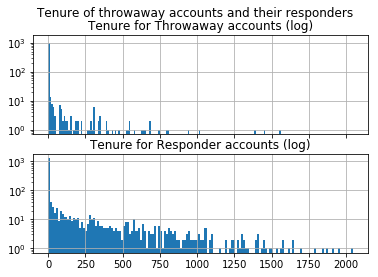

In [169]:
#comparing the tenure for the responders and the throwaway users...
f, axarr = plt.subplots(2, sharex=True, sharey=True)
axarr[0].set_title('Tenure for Throwaway accounts (log)')
axarr[0].set_yscale('log')
df_Throwaway['tenure'].hist(ax=axarr[0], stacked=False, bins=150)
axarr[1].set_title('Tenure for Responder accounts (log)')
axarr[1].set_yscale('log')
Throwaway_responders['tenure'].hist(ax=axarr[1], stacked=False, bins=150)
f.suptitle('Tenure of throwaway accounts and their responders')

In [253]:
Separate_Response = Joined.reset_index()

In [254]:
Separate_Response

,link_id,created_utc,Mommit,Parenting,daddit,archived,author,author_flair_css_class,author_flair_text,body,controversiality,distinguished,downs,edited,gilded,name,parent_id,removal_reason,score,score_hidden,subreddit,ups,body_tokenized,Stroller/Carrier selection,Food prep,Babyproofing,Tech & Media Consumption,Child media,Child play,Sociopolitical beleifs,Children Books,Cloth diapers,Work-life Balance,Breastfeeding,Money discussion,Early dev,Dev. & sib. interaction,Gift ideas,Child sickness,Time-chore mngt,Education,Preg & birth,Psych state of child & Parent,Congrats/announcements,Judgement,Discipline,Lang dev,Parenting hardships,Interaction with (extended)fam.,Child abuse/custody,Funny,Traveling & vacations,Parenting ID,Vaccines,Teen/sex talk,Corp. punishment,Potty training,Sleep training,comment_length,positive_emotion,negative_emotion,created_utcmin,created_utcmax,tenure,ThrowAuth,ThrowBody,DadBody,DadAuthor,MomBody,MomAuthor,Throwaway,Respond
0,t3_6d8mw,2008-04-09 15:16:05,0,1,0,True,kickstand,0,0,now you tell me. :-(,0,0,0.0,1970-01-01,0,t1_c03o5z1,t3_6d8mw,0.0,1,False,Parenting,1.0,[tel],0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.510000,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.000000,6,0.000000,0.000000,2008-04-09 15:16:05,2014-12-09 23:43:23,2435,False,False,False,False,False,False,0,False
1,t3_6d8mh,2008-04-09 15:17:46,0,1,0,True,kickstand,0,0,"at our house, the tooth fairy leaves one shiny $1 coin with a dead white president's face on it.\n\nhttp://www.usmint.gov/mint_programs/$1coin/index.cfm?flash=yes",0,0,0.0,1970-01-01,0,t1_c03o5zp,t3_6d8mh,0.0,1,False,Parenting,1.0,"[hous, too, fairy, leav, on, shiny, coin, dead, whit, presid, fac]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.626910,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.000000,19,0.000000,0.050000,2008-04-09 15:16:05,2014-12-09 23:43:23,2435,False,False,False,False,False,False,0,False
2,t3_7l42c,2008-12-23 14:58:04,0,1,0,True,kickstand,0,0,"it's not really much of a guide, is it?",0,0,0.0,1970-01-01,0,t1_35d8,t3_7l42c,0.0,3,False,Parenting,3.0,"[real, much, guid]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.755000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.000000,9,0.000000,0.000000,2008-04-09 15:16:05,2014-12-09 23:43:23,2435,False,False,False,False,False,False,0,False
3,t3_6ikpd,2008-05-08 19:14:57,0,1,0,True,kickstand,0,0,"whatever you do, don't make reading a chore. it's the most fun thing in the world, treat it as such.",0,0,0.0,1970-01-01,0,t1_c03y7ux,t3_6ikpd,0.0,1,False,Parenting,1.0,"[whatev, mak, read, chor, fun, thing, world, tre]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.149695,0.164569,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.397008,0.00000,0.186506,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.000000,20,0.000000,0.000000,2008-04-09 15:16:05,2014-12-09 23:43:23,2435,False,False,False,False,False,False,0,False
4,t3_7xo64,2009-02-16 15:54:40,0,1,0,True,kickstand,0,0,"just because you have two kids doesn't mean they are going to get along, or even like each other.",0,0,0.0,1970-01-01,0,t1_c07p56l,t3_7xo64,0.0,1,False,Parenting,1.0,"[two, kid, mean, going, get, along, ev, lik]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.460527,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.432

In [255]:
#now change the name of the user so that when pivoting the table, the responses
#would not be taken with all the other responses of the user
Separate_Response.loc[Separate_Response.Respond == 1, 'author'] = Separate_Response['author']+'resp'

In [257]:
Separate_Response[Separate_Response['Respond']==1]

,link_id,created_utc,Mommit,Parenting,daddit,archived,author,author_flair_css_class,author_flair_text,body,controversiality,distinguished,downs,edited,gilded,name,parent_id,removal_reason,score,score_hidden,subreddit,ups,body_tokenized,Stroller/Carrier selection,Food prep,Babyproofing,Tech & Media Consumption,Child media,Child play,Sociopolitical beleifs,Children Books,Cloth diapers,Work-life Balance,Breastfeeding,Money discussion,Early dev,Dev. & sib. interaction,Gift ideas,Child sickness,Time-chore mngt,Education,Preg & birth,Psych state of child & Parent,Congrats/announcements,Judgement,Discipline,Lang dev,Parenting hardships,Interaction with (extended)fam.,Child abuse/custody,Funny,Traveling & vacations,Parenting ID,Vaccines,Teen/sex talk,Corp. punishment,Potty training,Sleep training,comment_length,positive_emotion,negative_emotion,created_utcmin,created_utcmax,tenure,ThrowAuth,ThrowBody,DadBody,DadAuthor,MomBody,MomAuthor,Throwaway,Respond
55339,t3_gfy8c,2011-04-02 18:54:57,0,1,0,True,throwaway123454321resp,0,0,"for the love of god, do not buy everything new. stroller, carseat, clothes, crib, mattress, swing, everything - great deals can be had on craigslist for pennies on the dollar. everybody has the feeling or the inclination that if they don't spend just a little more on something just a little better, or something that is new that you are somehow shortchanging your baby. it's bullcrap. don't fall for it. clothes especially. newborn and 1-3 months may get worn once or twice before they are too big for them. if you have some family or close friends, cask if you can even borrow some clothes.\n\nyou may not believe me now, but you will in a year or two.\n",0,0,0.0,1970-01-01 00:00:00,0,t1_c1nhyq9,t3_gfy8c,0.0,2,False,Parenting,2.0,"[lov, god, buy, everyth, new, stroller, cars, cloth, crib, mattress, swing, everyth, gre, deal, craigsl, penny, doll, everybody, feel, inclin, spend, littl, someth, littl, bet, someth, new, somehow, shortchang, baby, bullcrap, fal, cloth, espec, newborn, month, may, get, worn, twic, big, famy, clos, friend, cask, ev, borrow, cloth, may, believ, year, two]",0.161707,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.225248,0.106267,0.227201,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.107080,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.051377,126,0.033613,0.000000,2011-04-02 18:50:16,2015-01-23 22:09:35,1392,True,False,False,False,False,False,1,True
55340,t3_gh6y6,2011-04-02 19:00:38,0,1,0,True,throwaway123454321resp,0,0,"actually, is account is over a year old. it started as a throwaway and took on a life of it's own. it's my only account now. :d. so if it does work, i would love some reddit gold!",0,0,0.0,1970-01-01 00:00:00,0,t1_c1nhzlh,t1_c1nhyo0,0.0,1,False,Parenting,1.0,"[act, account, year, old, start, throwaway, took, lif, account, work, would, lov, reddit, gold]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.305418,0.000000,0.397736,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,41,0.026316,0.000000,2011-04-02 18:50:16,2015-01-23 22:09:35,1392,True,False,False,False,False,False,1,True
55341,t3_gh6y6,2011-04-03 18:01:27,0,1,0,True,throwaway123454321resp,0,0,"i guess it important to add that she was still wearing a flotation device. it wasn't a lifejacket, instead it was a rectangular block you tied into the small of her back. it not enough to keep her above the water, but she can with effort. we started with four 1-1 1/4"" blocks, and moved down three as she got better. after a few more swims i'll see how she does with two blocks.",0,0,0.0,1970-01-01 00:00:00,0,t1_c1nmdz7,t1_c1ni006,0.0,1,False,Parenting,1.0,"[guess, import, ad, stil, wear, flot, dev, lifejacket, inste

In [277]:
OnlySeparateResponse = prepare_data_for_models(Separate_Response)

In [288]:
print(len(OnlySeparateResponse[OnlySeparateResponse['Respond']==1]))
print(len(OnlySeparateResponse[OnlySeparateResponse['Throwaway']==1]))
print(len(OnlySeparateResponse.loc[(OnlySeparateResponse['Respond'] == 1) & OnlySeparateResponse['Throwaway']==1]))

1825
1824
739


In [286]:
OnlySeparateResponse[OnlySeparateResponse['Throwaway']==1]

,Babyproofing,Breastfeeding,Child abuse/custody,Child media,Child play,Child sickness,Children Books,Cloth diapers,Congrats/announcements,Corp. punishment,DadAuthor,DadBody,Dev. & sib. interaction,Discipline,Early dev,Education,Food prep,Funny,Gift ideas,Interaction with (extended)fam.,Judgement,Lang dev,MomAuthor,MomBody,Mommit,Money discussion,Parenting,Parenting ID,Parenting hardships,Potty training,Preg & birth,Psych state of child & Parent,Respond,Sleep training,Sociopolitical beleifs,Stroller/Carrier selection,Tech & Media Consumption,Teen/sex talk,ThrowAuth,ThrowBody,Throwaway,Time-chore mngt,Traveling & vacations,Vaccines,Work-life Balance,comment_length,controversiality,daddit,downs,gilded,negative_emotion,positive_emotion,removal_reason,score,tenure,ups,DM,PD,PM,PMD,Dad,Mom,Gendered
author,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-throwaway9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.807792,1.0,0.000000,0.000000,0.000000,0.000000,0.141682,False,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,1,0.000000,0.000000,0.000000,0.000000,46.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,-16.000000,1,-16.000000,False,False,False,False,0,0,0
-throwaway9resp,0.000000,0.000000,0.000000,0.023377,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.029168,0.000000,0.000000,0.0,0.0,0.0,0.076767,1.0,0.000000,0.057045,0.000000,0.000000,0.397761,True,0.000000,0.249337,0.000000,0.049629,0.000000,1.0,0.0,1,0.000000,0.000000,0.000000,0.000000,75.333333,0.000000,0.0,0.0,0.0,0.010116,0.007407,0.0,1.666667,1,1.666667,False,False,False,False,0,0,0
101throwmeaway101,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.510000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,False,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,1,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,1.000000,0,1.000000,False,False,False,False,0,0,0
1029throwaway384756,0.079705,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.201262,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.234655,0.000000,0.455628,0.000000,0.000000,0.0,0.0,0.0,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,False,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,1,0.000000,0.000000,0.000000,0.000000,72.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,2.000000,0,2.000000,False,False,False,False,0,0,0
1234throwawayyyy,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.938750,False,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,1,0.000000,0.000000,0.000000,0.000000,35.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,1.000000,0,1.000000,False,False,False,False,0,0,0
1234throwawayyyyresp,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.377500,0.000000,0.0,0.0,0.000000,0.180859,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.297323,True,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,1,0.000000,0.000000,0.000000,0.000000,32.000000,0.000000,0.0,0.0,0.0,0.000000,0.019231,0.0,1.500000,0,1.500000,False,False,False,False,0,0,0
129800throwaway,0.056812,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.485373,0.000000,0.0,0.0,0.0,0.000000,1.0,0.073849,0.000000,0.000000,0.000000,0.000000

In [289]:
#Exporting this dataframe that shows the responders to the Throwawy accounts only when they are actually responding to
#throwaway accounts
OnlySeparateResponse.to_pickle('OnlyResponsePartialUser.pickle')

In [290]:
df

,Mommit,Parenting,daddit,archived,author,author_flair_css_class,author_flair_text,body,controversiality,created_utc,distinguished,downs,edited,gilded,link_id,name,parent_id,removal_reason,score,score_hidden,subreddit,ups,body_tokenized,Stroller/Carrier selection,Food prep,Babyproofing,Tech & Media Consumption,Child media,Child play,Sociopolitical beleifs,Children Books,Cloth diapers,Work-life Balance,Breastfeeding,Money discussion,Early dev,Dev. & sib. interaction,Gift ideas,Child sickness,Time-chore mngt,Education,Preg & birth,Psych state of child & Parent,Congrats/announcements,Judgement,Discipline,Lang dev,Parenting hardships,Interaction with (extended)fam.,Child abuse/custody,Funny,Traveling & vacations,Parenting ID,Vaccines,Teen/sex talk,Corp. punishment,Potty training,Sleep training,comment_length,positive_emotion,negative_emotion,created_utcmin,created_utcmax,tenure,ThrowAuth,ThrowBody,DadBody,DadAuthor,MomBody,MomAuthor
0,0,1,0,True,kickstand,0,0,now you tell me. :-(,0,2008-04-09 15:16:05,0,0.0,1970-01-01,0,t3_6d8mw,t1_c03o5z1,t3_6d8mw,0.0,1,False,Parenting,1.0,[tel],0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.510000,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.000000,6,0.000000,0.000000,2008-04-09 15:16:05,2014-12-09 23:43:23,2435,False,False,False,False,False,False
1,0,1,0,True,kickstand,0,0,"at our house, the tooth fairy leaves one shiny $1 coin with a dead white president's face on it.\n\nhttp://www.usmint.gov/mint_programs/$1coin/index.cfm?flash=yes",0,2008-04-09 15:17:46,0,0.0,1970-01-01,0,t3_6d8mh,t1_c03o5zp,t3_6d8mh,0.0,1,False,Parenting,1.0,"[hous, too, fairy, leav, on, shiny, coin, dead, whit, presid, fac]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.626910,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.000000,19,0.000000,0.050000,2008-04-09 15:16:05,2014-12-09 23:43:23,2435,False,False,False,False,False,False
2,0,1,0,True,kickstand,0,0,"it's not really much of a guide, is it?",0,2008-12-23 14:58:04,0,0.0,1970-01-01,0,t3_7l42c,t1_35d8,t3_7l42c,0.0,3,False,Parenting,3.0,"[real, much, guid]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.755000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.000000,9,0.000000,0.000000,2008-04-09 15:16:05,2014-12-09 23:43:23,2435,False,False,False,False,False,False
3,0,1,0,True,kickstand,0,0,"whatever you do, don't make reading a chore. it's the most fun thing in the world, treat it as such.",0,2008-05-08 19:14:57,0,0.0,1970-01-01,0,t3_6ikpd,t1_c03y7ux,t3_6ikpd,0.0,1,False,Parenting,1.0,"[whatev, mak, read, chor, fun, thing, world, tre]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.149695,0.164569,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.397008,0.00000,0.186506,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.000000,20,0.000000,0.000000,2008-04-09 15:16:05,2014-12-09 23:43:23,2435,False,False,False,False,False,False
4,0,1,0,True,kickstand,0,0,"just because you have two kids doesn't mean they are going to get along, or even like each other.",0,2009-02-16 15:54:40,0,0.0,1970-01-01,0,t3_7xo64,t1_c07p56l,t3_7xo64,0.0,1,False,Parenting,1.0,"[two, kid, mean, going, get, along, ev, lik]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.460527,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.432806,0.00000,0.000000,0.000000,0.000000,0.0,0.00000